# **#런타임 - 런타임 유형 변경 - 하드웨어 가속기를 GPU로 setting 해주세요**

# **6.4. Multiple Input and Multiple Output Channels**

RGB처럼 image에는 channel dimesion이 있다.

**6.4.1. Multiple Input Channels**

convolutional kernel과 input channel의 갯수는 같아야 한다.
channel의 갯수, kernel의 가로, 세로를 고려하면 kernel의 shape은 아래와 같다.

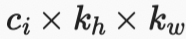

2개의 input channel이 각각의 kernel과 cross-correlation 계산을 하여 나온 값을 합산하면 아래와 같이 1개의 channel이 있는 output으로 계산된다.

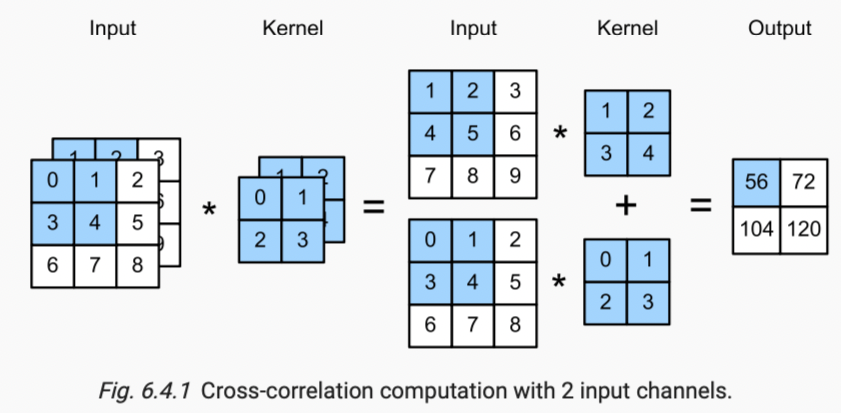

In [ ]:
import torch
from d2l import torch as d2l

# corr2d + multichannel 추가 = corr2d_multi_in 입니다
def corr2d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
#6.2에서 나왔던 corr2d 복습
from torch import nn

def corr2d(X, K):  
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
#Python 기초 ~ : zip
numbers = [1, 2, 3]
letters = ["A", "B", "C"]
for pair in zip(numbers, letters):
     print(pair)

(1, 'A')
(2, 'B')
(3, 'C')


In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

**6.4.2. Multiple Output Channels**

최근에 많은 neural network architercture들은 spatial resolution을 희생해서 channel 갯수를 늘리는 방법을 사용한다. 이렇게 늘어난 channel들은 (단순하게 생각하면) 각각의 channel이 어떠한 feature에 반응하는 channel이 된다.



요약하면 kernel의 갯수를 조정해서 channel을 늘릴 수 있다. output channel의 갯수를 고려하면 kernel의 수는 input의 channel 갯수, output의 channel 갯수, 가로, 세로를 따져야 하므로 아래와 같다.

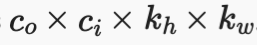

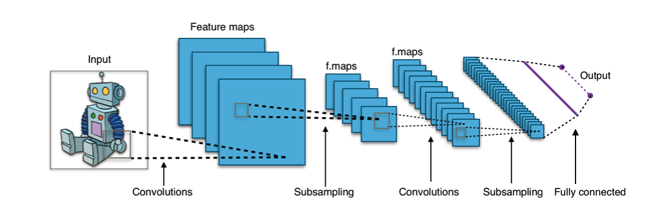

In [ ]:
# corr2d_multi_in + output channel의 갯수를 고려 = corr2d_multi_in_out 입니다

def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of `K`, and each time, perform
    # cross-correlation operations with input `X`. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
#K가 어떤 tensor 인지 확인해 봅시다~
print(K)

tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])


In [ ]:
K = torch.stack((K, K + 1, K + 2), 0) #K를 K,K에 1을 더한 것, K에 2를 더한 것을 더해서 차원을 쌓은 상태로로 업데이트 합니다~ 
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
print(K)

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]],


        [[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])


In [ ]:
print(X)

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]],

        [[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]])


In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])


K.shape = torch.Size([3, 2, 2, 2]) 이었는데
가로2, 세로2, input channel(X) 2, output channel(corr2d_multi_in_out(X, K))3 이기 때문이다

**6.4.3. 1×1 Convolutional Layer**

가로, 세로가 1씩 해당되는 1×1 Convolutional Layer는 가로, 세로 크기를 줄이지 않고 그대로 유지한다. 그리고 한번에 1 pixel만 보기 때문에 pattern을 인식하는데도 도움이 안된다. 그럼에도 불구하고 1×1 Convolutional을 하는 것은 channel 갯수를 바꾸어 줄 수 있기 때문이다.

요약 : 1×1 Convolutional은 channel 갯수를 바꿀 때 쓴다

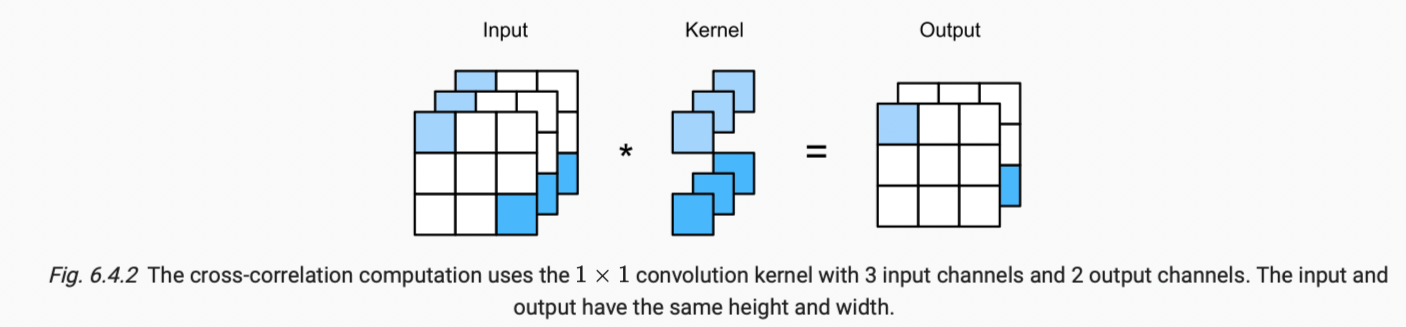

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully-connected layer - matmul은 행렬곱 함수입니다~
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

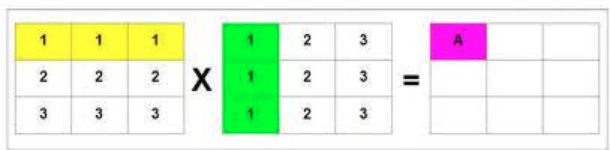

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

In [ ]:
print(X)

tensor([[[ 0.5013, -0.1114, -0.1704],
         [-1.1906, -0.0663, -0.7515],
         [-0.4507,  0.2069, -0.6333]],

        [[ 0.6039,  0.3384, -1.2353],
         [-0.7972,  0.2150, -0.0390],
         [ 0.4752,  0.1202, -0.5871]],

        [[ 0.5765, -2.6463, -0.7397],
         [-0.3261, -0.5699,  0.2031],
         [ 0.3439,  1.4494, -0.6029]]])


In [ ]:
X.shape

torch.Size([3, 3, 3])

In [ ]:
print(K)

tensor([[[[-1.0379]],

         [[-0.2675]],

         [[ 0.0604]]],


        [[[ 1.9344]],

         [[ 0.6195]],

         [[ 1.3193]]]])


In [ ]:
K.shape

torch.Size([2, 3, 1, 1])

In [ ]:
X.reshape((3,3*3))

tensor([[-0.7482, -1.2004, -0.3248,  0.6315, -0.9318,  0.1589, -0.5267,  0.0222,
         -0.0342],
        [-0.5534,  0.8271, -0.1641, -1.2669, -1.1622,  2.2444,  0.8960, -1.4390,
          0.4245],
        [-0.2388, -0.2140, -0.4798, -0.0272, -0.6768, -0.3049, -1.6644,  0.2858,
          0.2040]])

In [ ]:
K.reshape((2,3))

tensor([[-1.0379, -0.2675,  0.0604],
        [ 1.9344,  0.6195,  1.3193]])

In [ ]:
print(Y1)

tensor([[[ 0.9101,  1.0118,  0.3521],
         [-0.3182,  1.2372, -0.7837],
         [ 0.2066,  0.3791, -0.0657]],

        [[-2.1052, -2.0920, -1.3630],
         [ 0.4008, -3.4154,  1.2956],
         [-2.6596, -0.4716,  0.4658]]])


In [ ]:
print(Y2)

tensor([[[ 0.9101,  1.0118,  0.3521],
         [-0.3182,  1.2372, -0.7837],
         [ 0.2066,  0.3791, -0.0657]],

        [[-2.1052, -2.0920, -1.3630],
         [ 0.4008, -3.4154,  1.2956],
         [-2.6596, -0.4716,  0.4658]]])


In [ ]:
float(torch.abs(Y1 - Y2).sum())

0.0

In [ ]:
assert True

In [ ]:
#assert False

# **6.5. Pooling**

receptive field를 넓혀서 이미지 전체를 통합적으로 보기 위해서 Pooling을 한다.
모델이 이미지 전체를 통합적으로 보지 못하면 이미지가 오른쪽으로 1픽셀만 움직여도도 edge등의 feature를 놓치게 된다.

**6.5.1. Maximum Pooling and Average Pooling**

Pooling에는 주어진 영역에서 최대값을 뽑는 maximum pooling과 주어진 영역의 평균값을 뽑는 average pooling이 있다. pooling은 kernel과 다르게 parameter를 가지지 않고 pooling operator(max or average)만을 가지는 것이 특징이다. 

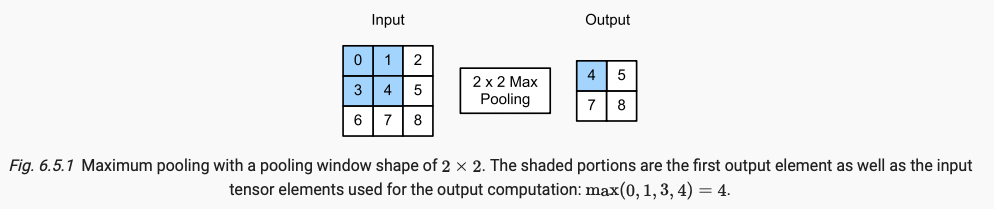

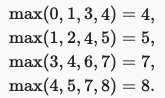

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

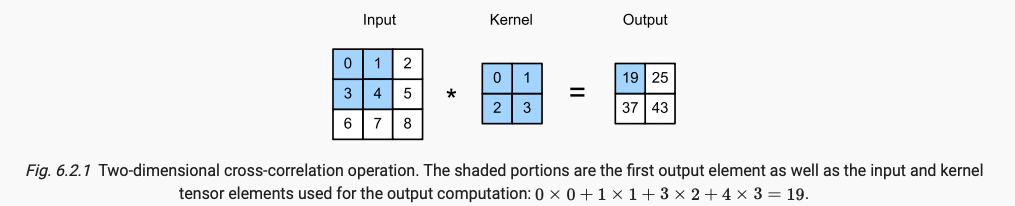

image.png

In [ ]:
torch.zeros(2,2)

tensor([[0., 0.],
        [0., 0.]])

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

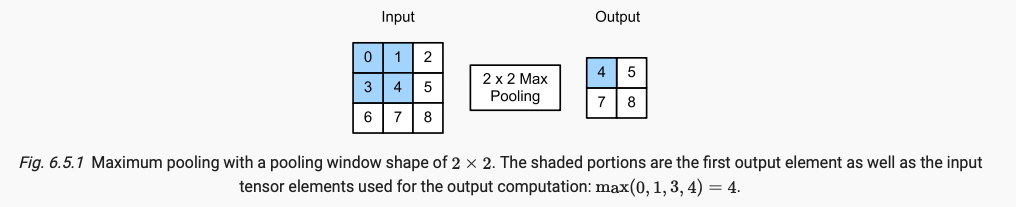

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

**6.5.2. Padding and Stride**

Pooling에서도 마찬가지로 padding, stride를 지정할 수 있다.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3) #stride를 따로 지정하지 않으면 window 값을 따라간다, 즉 여기서는 strid =3으로 default 지정
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
#stride를 1로 지정해보자~
pool2d = nn.MaxPool2d(3,stride=1)
pool2d(X)

tensor([[[[10., 11.],
          [14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

**6.5.3. Multiple Channels**

channel이 복수인 경우에도 maxpooling을 똑같이이 적용할 수 있다.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# **6.6. Convolutional Neural Networks (LeNet)**

AT&T Bell Lab의 Yann LeCun이  backpropagation을 사용하는 CNN에 대한 연구에 대한 첫 컨셉을 1989년 발표하였고 이후 개량해서 1998년 LeNet을 공개하였다. 공개 당시 support vector machine에 비해서 우월한 성능을 보였고 ATM에서 숫자를 인식하는 용도로 사용되기도 하였고 현재도 일부 ATM에서는 아직도 사용되고 있다.

**6.6.1. LeNet**

LeNet은 2 부분으로 구성된다.

1.   2개의 convolutional layers로 구성된 convolutional encoder
2.   3개의 fully-connected layers로 구성된 dense block



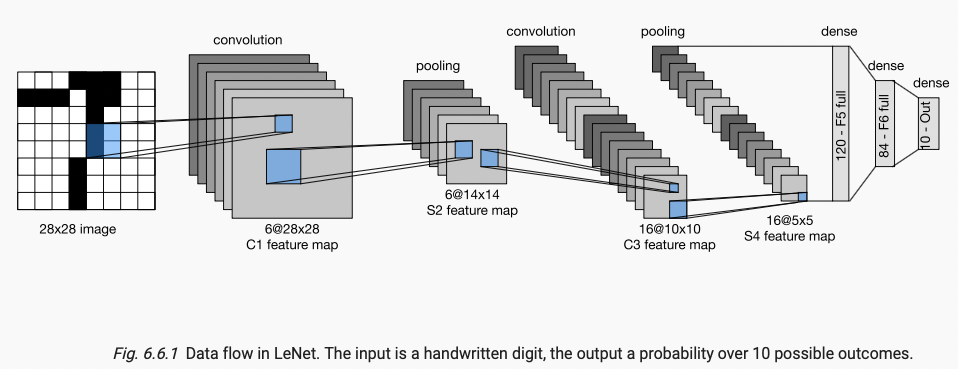

Convolutional block은 convolutional layers(5x5 kernel) + sigmoid activation function +  average pooling operation(2x2) 으로 구성되어 있다.

*   첫번째 convolutional layer는 6 output channels을 가진다.
*   두번째 convolutional layer는 16 output channels을 가진다.








Convolutional block을 지나면 dense block에 들어가야 해서 flatten을 시켜준다.

3개의 fully-connected layers를 지나게 된다. 각각 output은 120, 84, 10개이다.

숫자를 맞추는 것이기 때문에 마지막 output은 10개이다.(0-9)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

#nn.Sequential 클래스는 nn.Linear, nn.ReLU(활성화 함수) 같은 모듈들을 인수로 받아서 순서대로 정렬해서 모델을 만든다

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

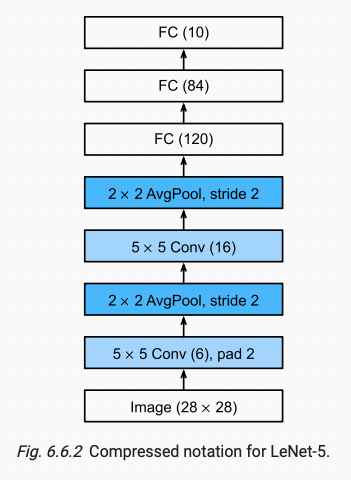

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


convolutional block을 거치면서 가로, 세로 값이 작아지는 것을 볼 수 있다 ( 28 > 14 > 10 > 5)

**6.6.2. Training**

Fashion-MNIST로 training 시켜본다.

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CNN은 parameter가 적긴 하지만 대신에 parameter간에 더 많은 곱을 하도록 되어 있어서 GPU를 쓰는 것이 좋다.

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())